In [1]:
import pandas as pd
import math

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
from xgboost import plot_tree
from sklearn.metrics import r2_score

df_train = pd.read_csv('./csv/train.csv')
df_store = pd.read_csv('./csv/stores.csv')
df_feat = pd.read_csv('./csv/features.csv')


In [2]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_feat['Date'] = pd.to_datetime(df_feat['Date'])

In [3]:
df = pd.merge(df_train, df_feat, on=['Store', 'Date', 'IsHoliday'], how='left' )
df = pd.merge(df, df_store, on=['Store'], how='left' )

In [4]:
fill_na_cols = [ 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5' ]

for c in fill_na_cols:
    df[c] = df[c].fillna(0)


In [5]:
df['year'] = df['Date'].dt.year
df['week'] = df['Date'].dt.week
df['month'] = df['Date'].dt.month

# df = df.drop(columns = ['Date'])

/tmp/ipykernel_2157/3234748729.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df['Date'].dt.week


In [6]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,year,week,month
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,2010,5,2
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,2010,6,2
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,2010,7,2
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,2010,8,2
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,2010,9,3


In [7]:
label=LabelEncoder() # True-False --> 0-1

cols = ['Type', 'IsHoliday']

for c in cols:
    df[c] = label.fit_transform(df[c])
    df[c] = df[c].astype('category')

In [8]:
df = df.sample(frac=1, random_state=1) # shuffle

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 367951 to 128037
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  category      
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     421570 non-null  float64       
 8   MarkDown2     421570 non-null  float64       
 9   MarkDown3     421570 non-null  float64       
 10  MarkDown4     421570 non-null  float64       
 11  MarkDown5     421570 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  category      
 15  Size        

In [81]:
import matplotlib.pyplot as plt

def WMAE(pred, gtruth, is_holiday):
    weights = is_holiday.astype('int').apply(lambda x: 5 if x==1 else 1) 
    tmp = weights * abs(pred-gtruth)
    return tmp.sum()/weights.sum()

def train_boost(df_t, df_v, 
               features = None,
               sumb = False,
               depth = 6,
               N_ = 300):
    # feature selection
    if features is None:
        features = ['Weekly_Sales', 'Store','Dept','IsHoliday','Size','week','Type', 'Date','year']
    # df = df_0[ features ] # 
    # split train and evaluation
    """
    train_num = int( 0.8 * len(df) )
    df_train = df[:train_num]
    df_val = df[train_num:]
    """
    df_train = df_t[features]
    df_val = df_v
    
    
    print("#(train)=",len(df_train), "#(val)", len(df_val))
    
    # train
    X_train = df_train.drop(columns = ['Weekly_Sales', 'Date'])
    Y_train = df_train['Weekly_Sales']


    reg = xgb.XGBRegressor(tree_method = 'gpu_hist', objective='reg:squarederror', max_depth=depth, n_estimators= N_, learning_rate=0.1, subsample = 0.9,
                      enable_categorical=True) # n_estimators -- #(tree)

    reg.fit(X_train, Y_train ) #saved in reg
    
    
    # train evaluation
    print("performance on training")
    pred = pd.Series( reg.predict(X_train) ).apply(lambda x: 0 if x < 0 else x )
    #pred = pd.Series( reg.predict(X_train) )
    
    r2 = r2_score( pred,Y_train.reset_index(drop=True) )
    mae = np.mean( np.absolute( np.array( Y_train.tolist() ) - pred ))
    wmae = WMAE(pred, Y_train.reset_index(drop=True), df_t['IsHoliday'].reset_index(drop=True))
    
    print("r2= ", r2)
    print("MAE= ", mae)
    print("WMAE= ", wmae)
    
    # plt.figure(figsize=(15, 10))
    plt.barh(X_train.columns, reg.feature_importances_)
    plt.show()
    # plt.savefig('./tmp.png', dpi=100)
    
    
    # test evaluation
    if not sumb: # not sumbmission, just evaluation
        print("performance on evaluation")
        df_val = df_v[features]
        X_val = df_val.drop(columns = ['Weekly_Sales', 'Date'])
        Y_val = df_val['Weekly_Sales']

        pred = pd.Series( reg.predict(X_val) ).apply(lambda x: 0 if x < 0 else x )
        #pred = pd.Series( reg.predict(X_val) )
        r2_v = r2_score( pred,Y_val.reset_index(drop=True) )
        mae_v = np.mean( np.absolute( np.array( Y_val.tolist() ) - pred ) )
        wmae_v = WMAE(pred, Y_val.reset_index(drop=True), 
             df_v['IsHoliday'].reset_index(drop=True))
        
        print("r2=", r2_v)
        print("MAE=", mae_v)
        print("WMAE=", wmae_v)
        
        return [r2,mae,wmae,r2_v, mae_v, wmae_v]
    else: # submission
        
        X_test = df_v[features[1:]].drop(columns = ['Date'])
        df_test_0 = df_v[features[1:]].copy()
        print(df_test_0.columns)
        pred = pd.Series( reg.predict(X_test) ).apply(lambda x: 0 if x < 0 else x )

        df_test_0['Weekly_Sales'] = pred
        def concat(x):
            return str( f"{x['Store']}_{x['Dept']}_{str(x['Date']).split(' ')[0]}" )
        df_test_0['Id'] = df_test_0.apply(lambda x: concat(x), axis=1)

        submission = df_test_0[['Id', 'Weekly_Sales']]
        submission.to_csv('submission.csv', index=False)
    
    return reg

#(train)= 337256 #(val) 84314
performance on training
r2=  0.9921148482837642
MAE=  1114.1361855614055
WMAE=  1126.8791124204918
performance on evaluation
r2= 0.9852344047533437
MAE= 1348.5775160095172
WMAE= 1426.541863817565


[[0.9921148482837642, 1114.1361855614055, 1126.8791124204918],
 [0.9852344047533437, 1348.5775160095172, 1426.541863817565]]

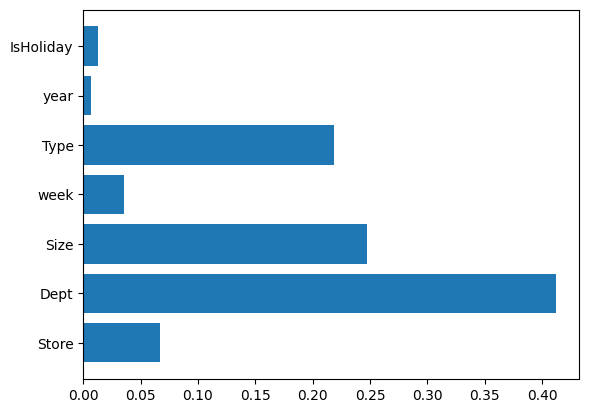

In [73]:
# test
train_num = int( 0.8 * len(df) )
df_train = df[:train_num]
df_val = df[train_num:]
feat= ['Weekly_Sales','Store', 'Dept', 'Size', 'week', 'Type', 'Date', 'year'] #, 'IsHoliday']
train_boost(df_train, df_val, sumb = False, depth= 10, N_ = 300,
           features = feat )

depth= 1
#(train)= 337256 #(val) 84314
performance on training
r2=  -1.6021988477811813
MAE=  10807.40243662833
WMAE=  11039.43109064034


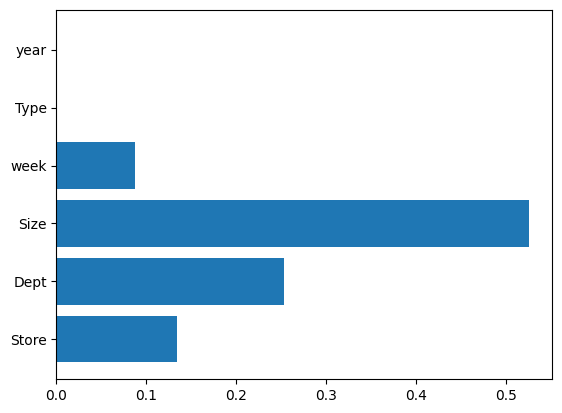

performance on evaluation
r2= -1.6246026747934126
MAE= 10758.20301880914
WMAE= 10949.51413880973
depth= 2
#(train)= 337256 #(val) 84314
performance on training
r2=  0.5218889097070569
MAE=  6772.138301852728
WMAE=  7013.81596770443


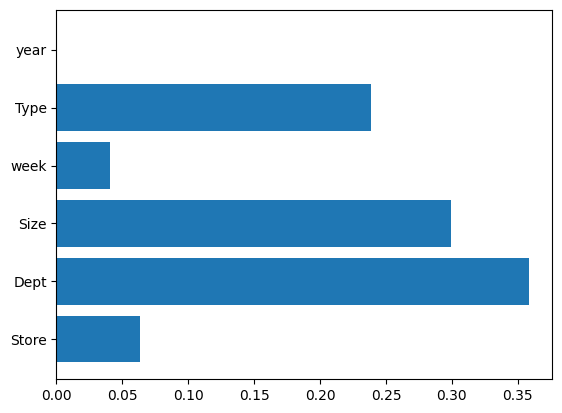

performance on evaluation
r2= 0.5046291964359069
MAE= 6749.893161601349
WMAE= 6982.687450740108
depth= 3
#(train)= 337256 #(val) 84314
performance on training
r2=  0.7660644104394211
MAE=  5142.203372820436
WMAE=  5365.173375192148


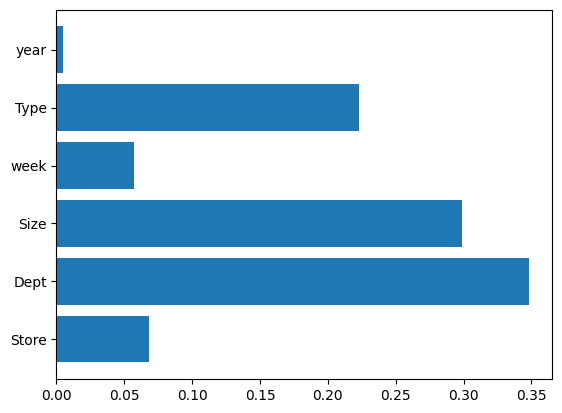

performance on evaluation
r2= 0.7551330955975125
MAE= 5127.444553527481
WMAE= 5361.737126055145
depth= 4
#(train)= 337256 #(val) 84314
performance on training
r2=  0.8547619209770042
MAE=  4195.578715636453
WMAE=  4413.043644517702


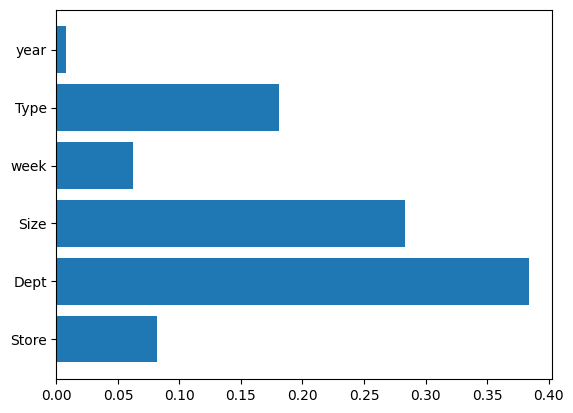

performance on evaluation
r2= 0.8464814355883463
MAE= 4197.774128399022
WMAE= 4419.060580064331
depth= 5
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9127661384743316
MAE=  3413.861346885805
WMAE=  3561.190747645296


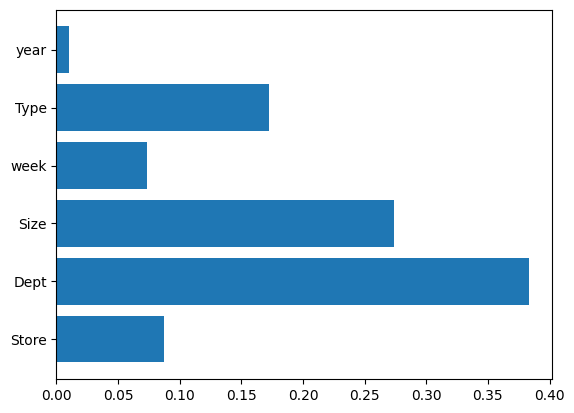

performance on evaluation
r2= 0.9079138847761882
MAE= 3433.409700094147
WMAE= 3587.3312591463127
depth= 6
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9453022978693839
MAE=  2769.2122129395675
WMAE=  2885.6580984990333


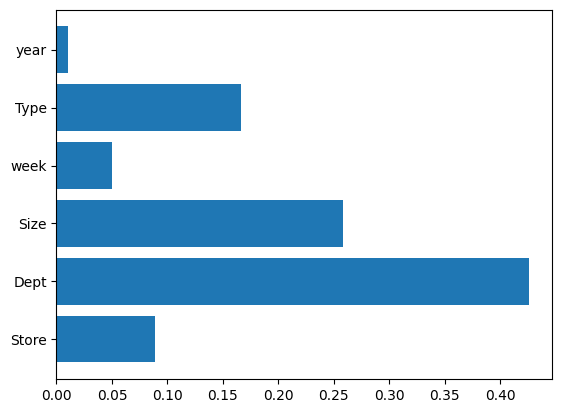

performance on evaluation
r2= 0.9411815136218987
MAE= 2805.500876047611
WMAE= 2929.5482482529446
depth= 7
#(train)= 337256 #(val) 84314
performance on training
r2=  0.967009732882056
MAE=  2212.13433381156
WMAE=  2296.047501918744


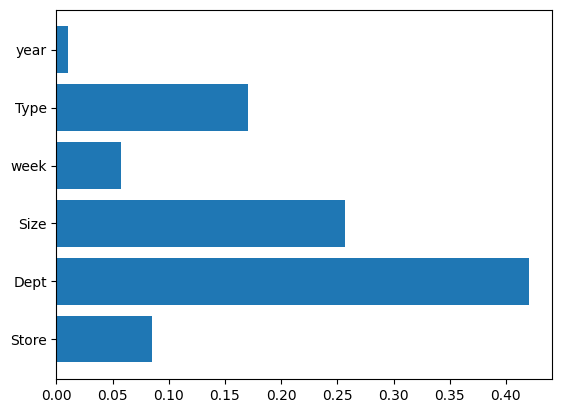

performance on evaluation
r2= 0.9625494513555661
MAE= 2277.0227923495468
WMAE= 2375.5316163193297
depth= 8
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9795603946180931
MAE=  1750.21592571601
WMAE=  1816.5566195497058


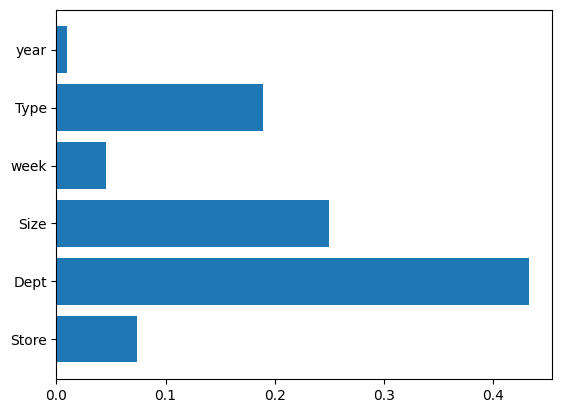

performance on evaluation
r2= 0.9743993033679887
MAE= 1857.9005195091777
WMAE= 1951.563464597922
depth= 9
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9875227049986057
MAE=  1382.2849716514534
WMAE=  1422.7130849016075


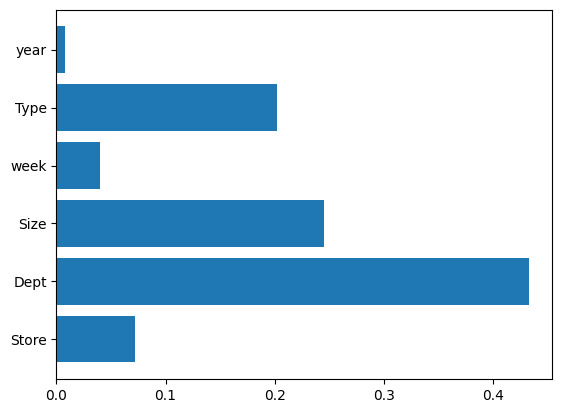

performance on evaluation
r2= 0.9813869302364139
MAE= 1543.831955944529
WMAE= 1621.2474875547705
depth= 10
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9920263482285888
MAE=  1116.6331379254916
WMAE=  1143.5314854428502


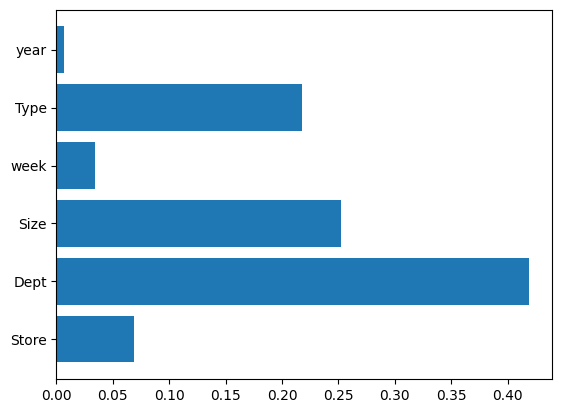

performance on evaluation
r2= 0.9852910884767765
MAE= 1348.4185556912348
WMAE= 1427.35127721853
depth= 11
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9952412925227473
MAE=  875.0154997046584
WMAE=  889.8644491079411


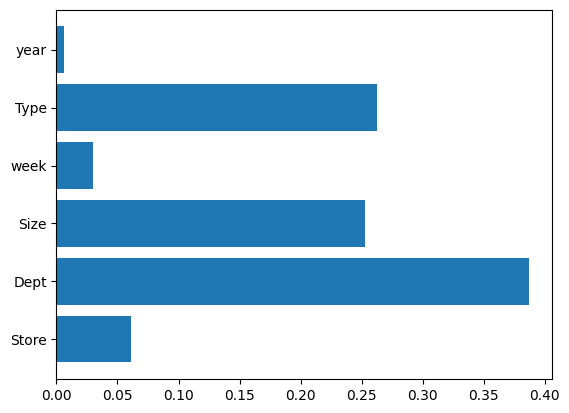

performance on evaluation
r2= 0.9875059755016623
MAE= 1200.6991400014701
WMAE= 1279.1652004939497
depth= 12
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9972595504338009
MAE=  681.4463064331098
WMAE=  686.5273615344045


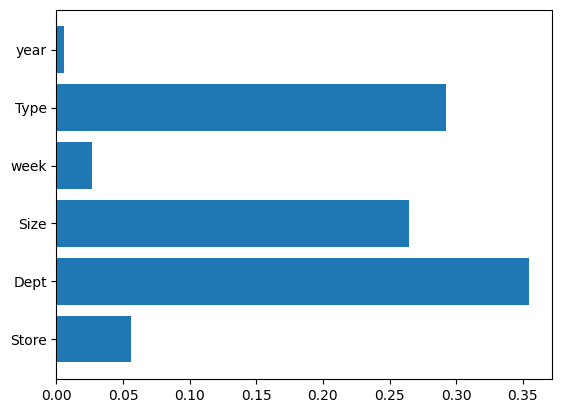

performance on evaluation
r2= 0.988256175292737
MAE= 1122.5356089638499
WMAE= 1204.938183495848
depth= 13
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9985153621022143
MAE=  517.0213411928972
WMAE=  515.4944329630791


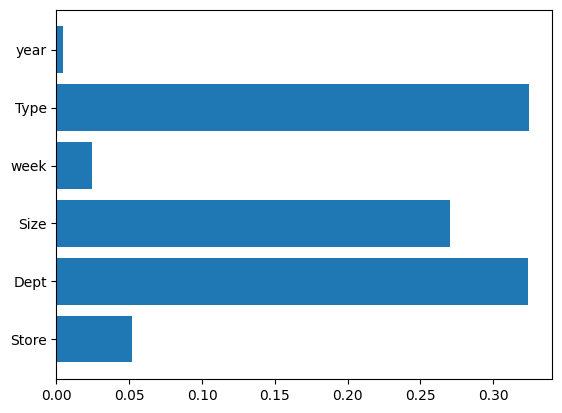

performance on evaluation
r2= 0.9886345698245854
MAE= 1084.6598483172127
WMAE= 1166.768783402921
depth= 14
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9992840191472654
MAE=  371.1137170881647
WMAE=  366.201382300487


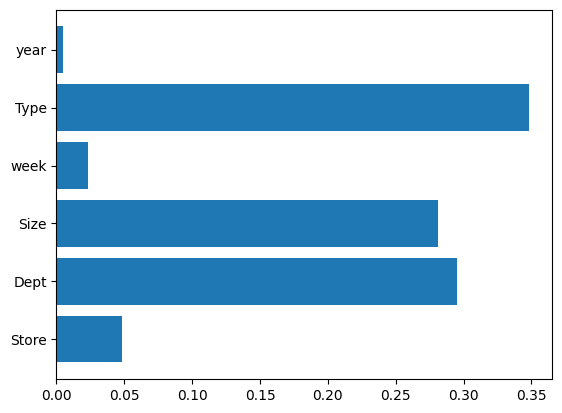

performance on evaluation
r2= 0.9882426080143639
MAE= 1074.6378398862844
WMAE= 1157.30707669466
depth= 15
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9997089420943952
MAE=  246.40984414745233
WMAE=  242.20338827670946


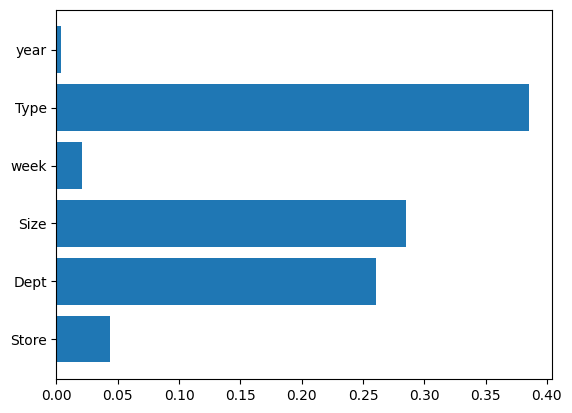

performance on evaluation
r2= 0.9877960176447831
MAE= 1077.0569969713174
WMAE= 1161.8254080831325
depth= 16
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9998949484803834
MAE=  152.44202933178553
WMAE=  149.0007667841276


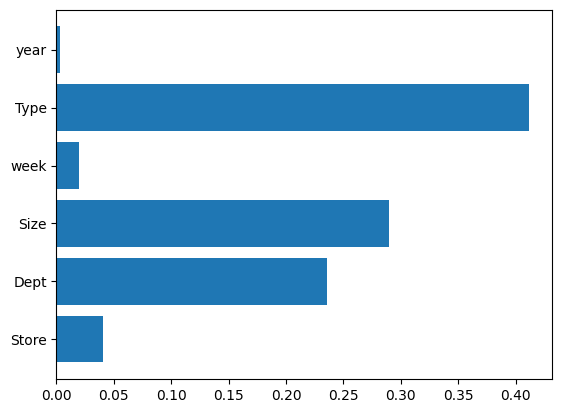

performance on evaluation
r2= 0.9871205325416866
MAE= 1089.6223891471404
WMAE= 1175.960541740415
depth= 17
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9999681108025313
MAE=  85.54300833031643
WMAE=  82.55643712479909


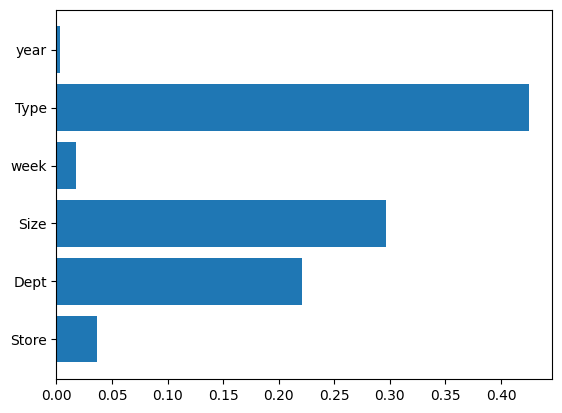

performance on evaluation
r2= 0.9866016048393839
MAE= 1104.6389929583434
WMAE= 1199.5425722949897
depth= 18
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9999919974277246
MAE=  42.776030804133725
WMAE=  41.27517293701089


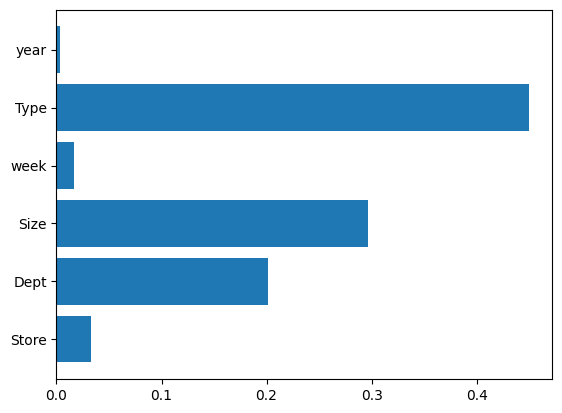

performance on evaluation
r2= 0.9861681884869635
MAE= 1116.6077207113788
WMAE= 1212.6969304240408
depth= 19
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9999981398045825
MAE=  19.437524006658574
WMAE=  18.662416695585353


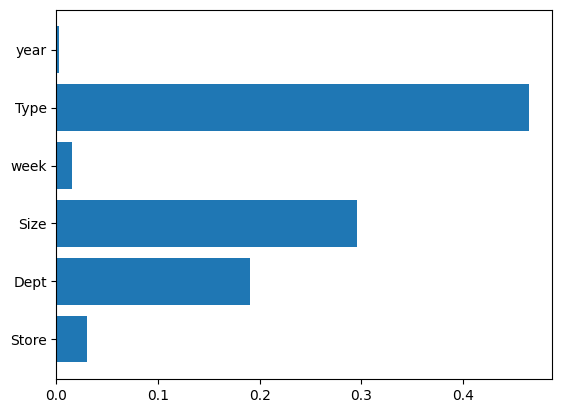

performance on evaluation
r2= 0.9858496070743521
MAE= 1128.1136282625876
WMAE= 1222.7592471347518


In [89]:
d_max = 20
feat= ['Weekly_Sales','Store', 'Dept', 'Size', 'week', 'Type', 'Date', 'year'] #, 'IsHoliday']
res = {}
serie = [[] for i in range(6)]
for d in range(1,d_max):
    print('=============================')
    print("depth=",d)
    tmp = train_boost(df_train, df_val, sumb = False, depth= d, N_ = 300, features = feat )
    res[d] = tmp
    for i in range(6):
        serie[i].append(tmp[i])

In [90]:
d_max = 20

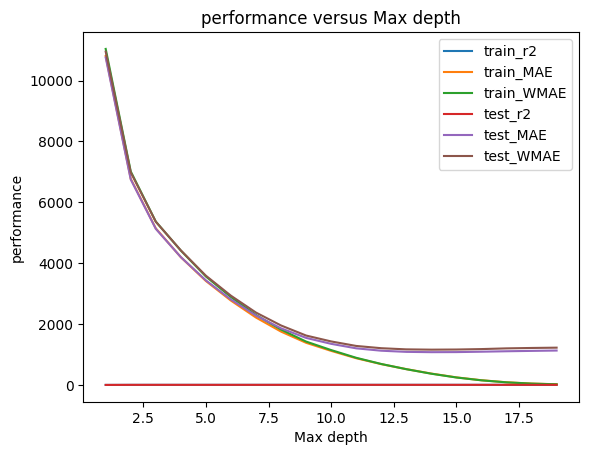

In [125]:
def res_plot(serie,y, title, xlabel = None, ylabel = "performance"):
    labelname = ["train_r2","train_MAE","train_WMAE","test_r2","test_MAE","test_WMAE"]

    for i in range(6):
        plt.plot(y, serie[i], label = labelname[i])
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

res_plot(serie,range(1,d_max),
        title= "performance versus Max depth",
        xlabel = 'Max depth')

In [96]:
# get best depth by WMAE on evaluation dataset
d_best = serie[5].index(min(serie[5])) +1 # from 1
d_best

14

N= 1
#(train)= 337256 #(val) 84314
performance on training
r2=  -131.3040082855635
MAE=  14426.244361016692
WMAE=  14659.27446571343


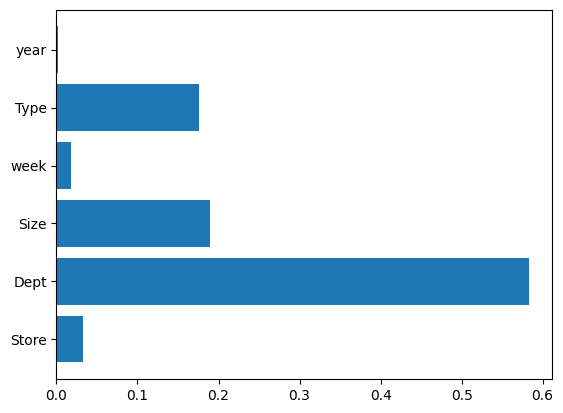

performance on evaluation
r2= -131.28822442783667
MAE= 14296.051369047093
WMAE= 14428.886704298407
N= 41
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9874101604962308
MAE=  1248.2140294309643
WMAE=  1283.1720585313824


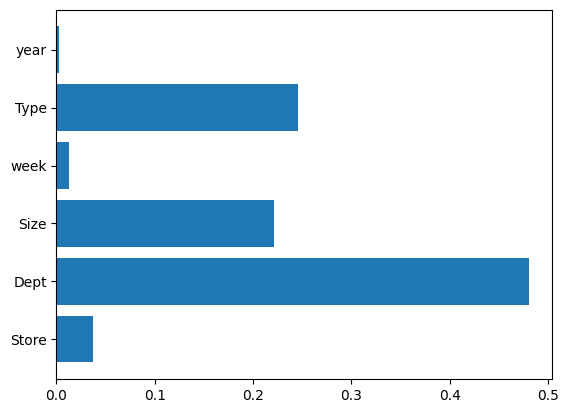

performance on evaluation
r2= 0.9782037052198331
MAE= 1478.3142339853537
WMAE= 1569.3846496108868
N= 81
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9950182844904008
MAE=  863.4675160479705
WMAE=  865.4472691871968


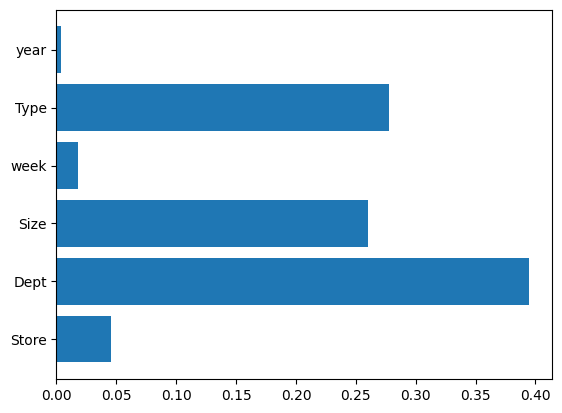

performance on evaluation
r2= 0.9855189823174917
MAE= 1234.6522334722463
WMAE= 1312.701196778275
N= 121
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9968192173496607
MAE=  711.8679906706291
WMAE=  709.784649303903


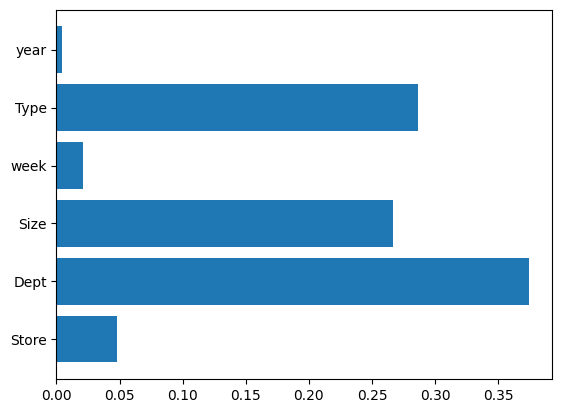

performance on evaluation
r2= 0.9869433542935641
MAE= 1159.9531312090444
WMAE= 1239.3689593843108
N= 161
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9978736177144083
MAE=  596.6234423304109
WMAE=  594.2756920403543


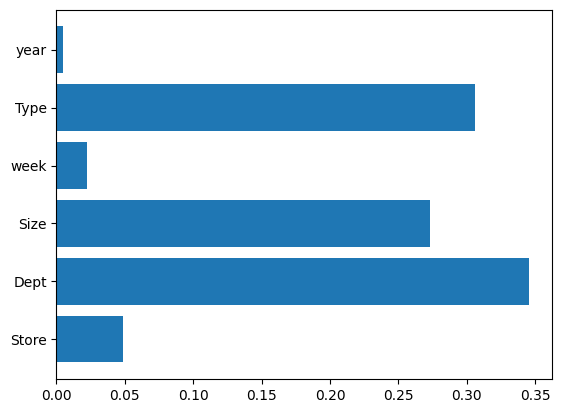

performance on evaluation
r2= 0.9876725972775445
MAE= 1115.8099933247133
WMAE= 1196.4554551586805
N= 201
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9984845811291098
MAE=  513.0788381434048
WMAE=  509.40537942219953


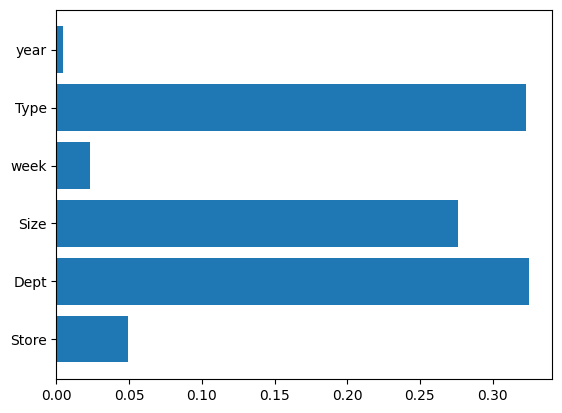

performance on evaluation
r2= 0.9879896619612225
MAE= 1093.7575683765833
WMAE= 1175.427071272427
N= 241
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9988937592817378
MAE=  447.4917302568225
WMAE=  443.1467109219653


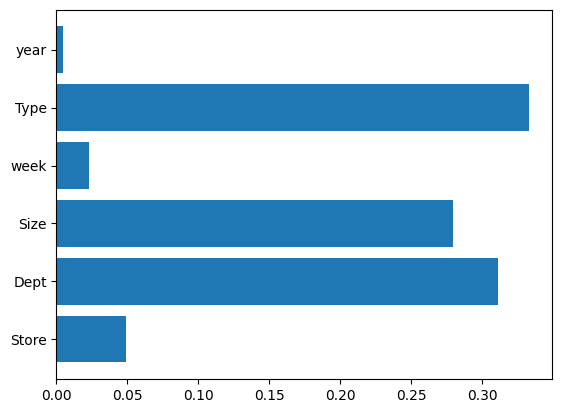

performance on evaluation
r2= 0.9881451957768786
MAE= 1082.3823505158414
WMAE= 1164.565223497246
N= 281
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9991761858776189
MAE=  393.9522361044508
WMAE=  388.5671228711775


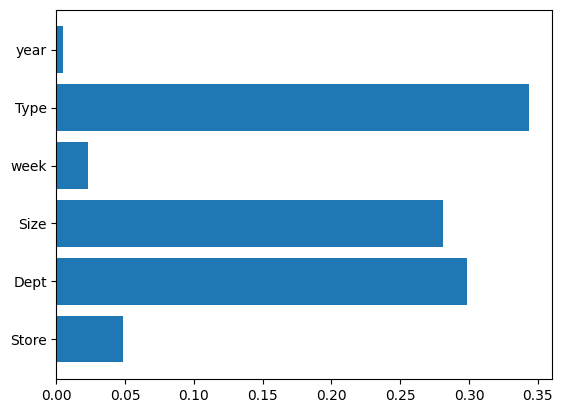

performance on evaluation
r2= 0.9882422903762959
MAE= 1075.9781205793313
WMAE= 1158.3844379887405
N= 321
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9993825265481676
MAE=  348.5317787804474
WMAE=  343.6175272806133


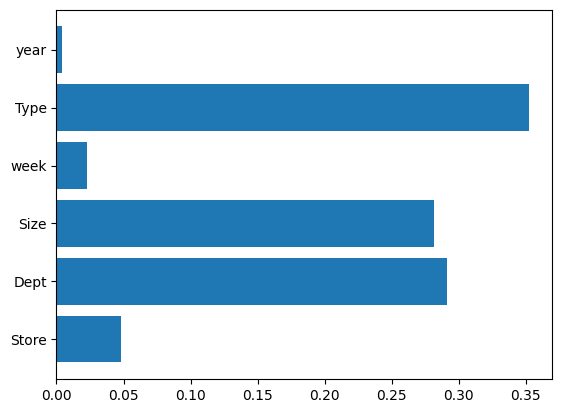

performance on evaluation
r2= 0.9882502620300109
MAE= 1073.5823989470925
WMAE= 1156.264898560848
N= 361
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995258102829883
MAE=  311.37757893631135
WMAE=  306.34507127170724


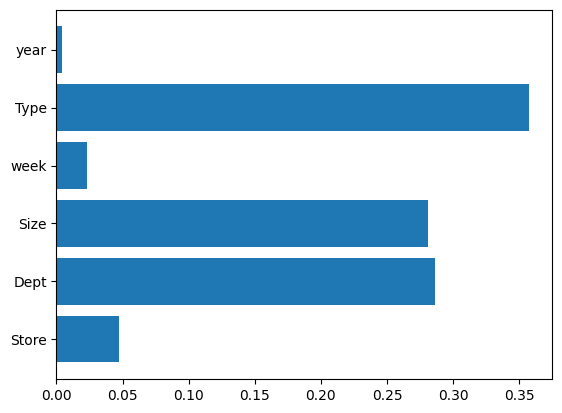

performance on evaluation
r2= 0.9882591527821029
MAE= 1072.6098133629455
WMAE= 1155.3387685946914
N= 401
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9996226159666198
MAE=  281.549842100295
WMAE=  276.77672035179677


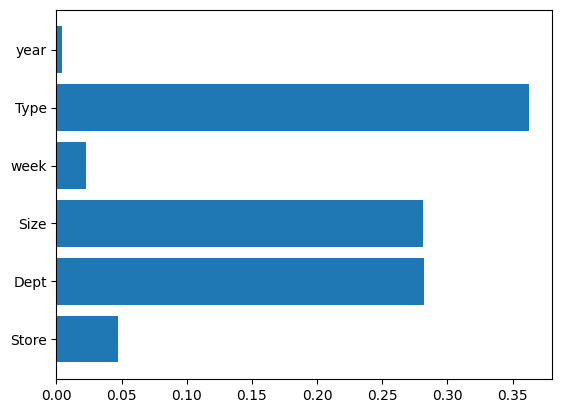

performance on evaluation
r2= 0.9882582303936814
MAE= 1072.72605945209
WMAE= 1155.1752618236108
N= 441
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9996941806113746
MAE=  256.41756462703745
WMAE=  251.80531622493683


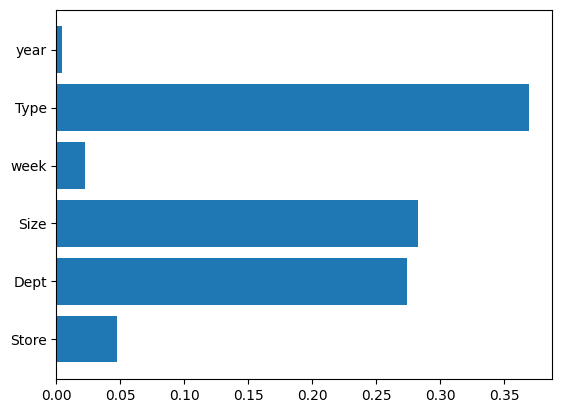

performance on evaluation
r2= 0.9882431572418455
MAE= 1073.8675287162073
WMAE= 1156.2968098538654
N= 481
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9997538504172737
MAE=  232.69070165044022
WMAE=  228.46465253874226


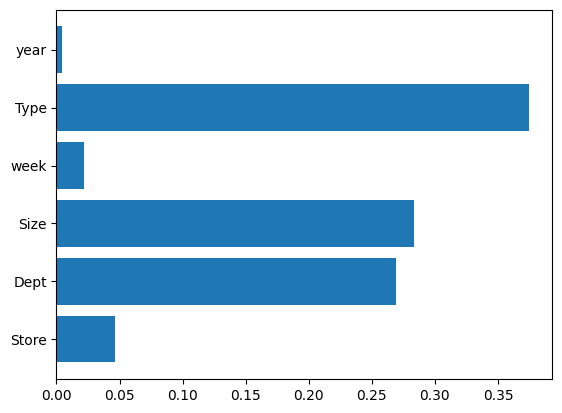

performance on evaluation
r2= 0.9882331659886047
MAE= 1075.1107285099822
WMAE= 1157.4008501385788


In [102]:
# roughly search for N
N_max = 500
feat= ['Weekly_Sales','Store', 'Dept', 'Size', 'week', 'Type', 'Date', 'year'] #, 'IsHoliday']
res_n = {}
serie_n = [[] for i in range(6)]
y = range(1,N_max,40)
for n in y:
    print('=============================')
    print("N=",n)
    tmp = train_boost(df_train, df_val, sumb = False, depth= d_best , N_ = n, features = feat )
    res_n[n] = tmp
    for i in range(6):
        serie_n[i].append(tmp[i])

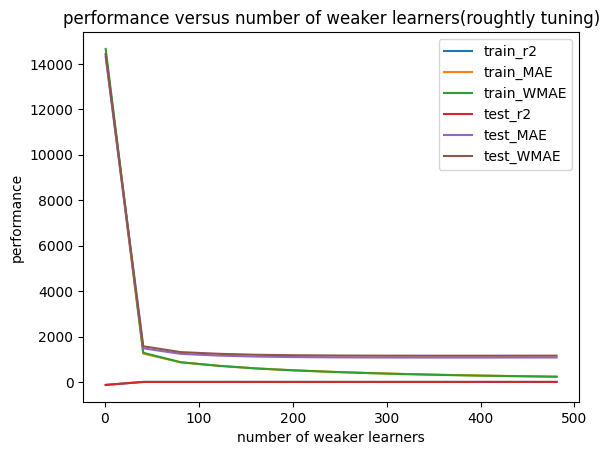

In [127]:
res_plot(serie_n,y,
        title= "performance versus number of weaker learners(roughtly tuning)",
        xlabel = 'number of weaker learners')

In [109]:
N_best = serie_n[5].index(min(serie_n[5]))
print(len(serie_n[5]))
print(serie_n[5])
N_best

13
[14428.886704298407, 1569.3846496108868, 1312.701196778275, 1239.3689593843108, 1196.4554551586805, 1175.427071272427, 1164.565223497246, 1158.3844379887405, 1156.264898560848, 1155.3387685946914, 1155.1752618236108, 1156.2968098538654, 1157.4008501385788]


10

In [110]:
# best N range
N_best = serie_n[5].index(min(serie_n[5]))
a,b=0,0
N_list = list(y)
if (serie_n[5][N_best-1] < serie_n[5][N_best+1]):
    a,b=N_list[N_best-1],N_list[N_best]
else:
    a,b=N_list[N_best],N_list[N_best+1]
a,b

(361, 401)

N= 361
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995258102829883
MAE=  311.37757893631135
WMAE=  306.34507127170724


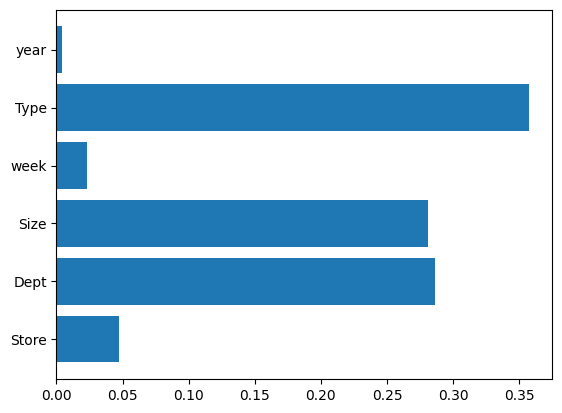

performance on evaluation
r2= 0.9882591527821029
MAE= 1072.6098133629455
WMAE= 1155.3387685946914
N= 362
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995276596881608
MAE=  310.7873017391883
WMAE=  305.6229065031985


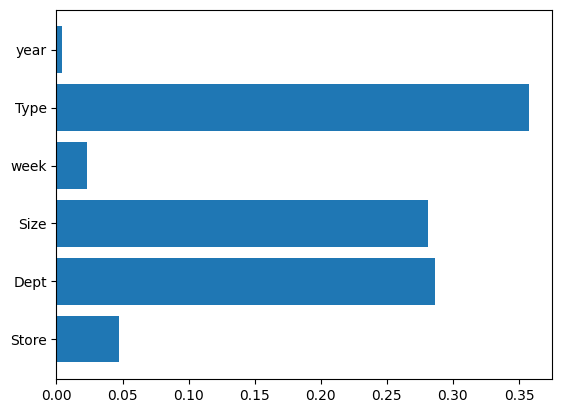

performance on evaluation
r2= 0.9882603654610084
MAE= 1072.6005501871057
WMAE= 1155.328937689624
N= 363
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995303587756105
MAE=  310.007491816902
WMAE=  304.93136037333477


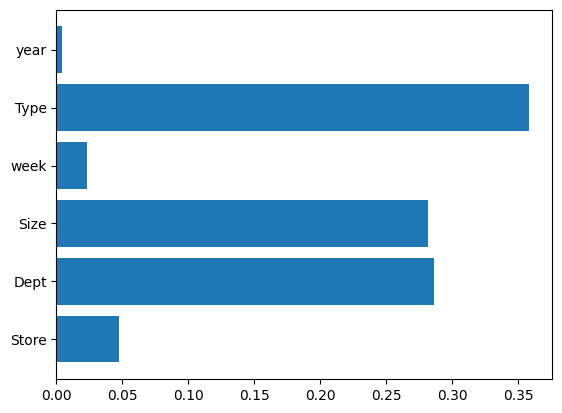

performance on evaluation
r2= 0.9882608067685817
MAE= 1072.607298889003
WMAE= 1155.3762153280306
N= 364
#(train)= 337256 #(val) 84314
performance on training
r2=  0.999533408458645
MAE=  309.09772098399924
WMAE=  304.0395446299404


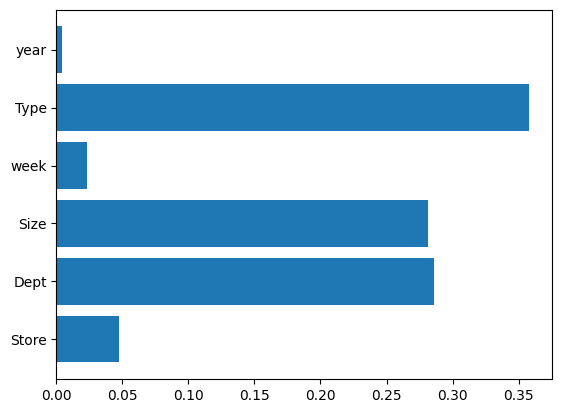

performance on evaluation
r2= 0.9882605504089335
MAE= 1072.5838322722561
WMAE= 1155.355367194814
N= 365
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995361240093464
MAE=  308.3017200478813
WMAE=  303.24978341547194


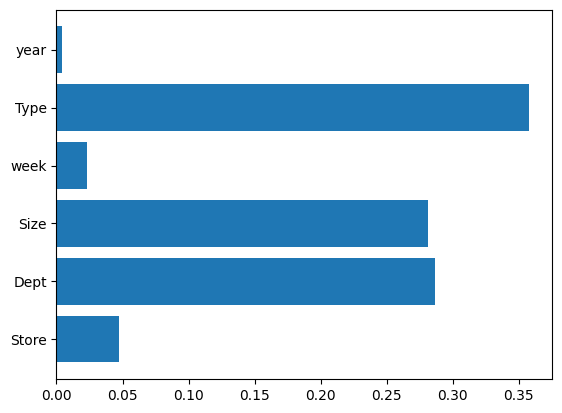

performance on evaluation
r2= 0.9882615025201856
MAE= 1072.4742377796313
WMAE= 1155.206974720701
N= 366
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995394511000629
MAE=  307.31979030916307
WMAE=  302.3650213754822


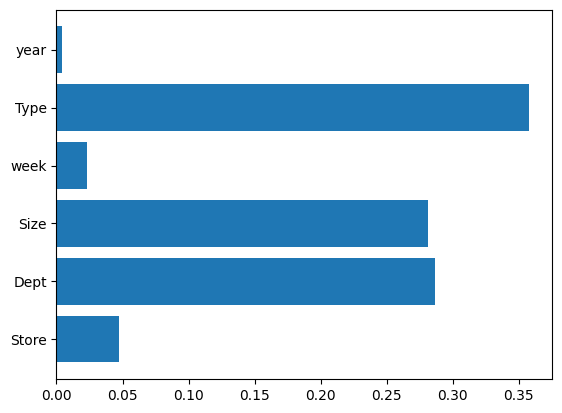

performance on evaluation
r2= 0.98826124102411
MAE= 1072.4426021990018
WMAE= 1155.1959180992983
N= 367
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995418907009787
MAE=  306.5641802082296
WMAE=  301.6721346915184


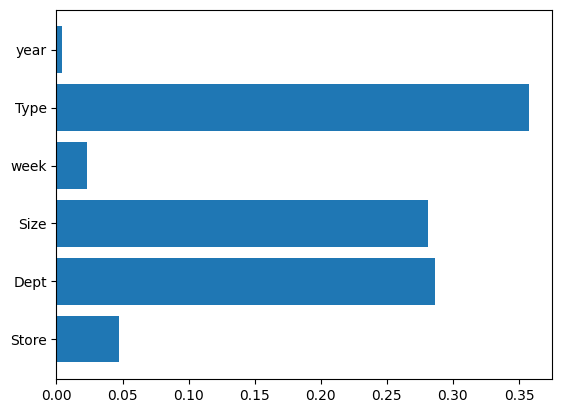

performance on evaluation
r2= 0.9882608011006974
MAE= 1072.4563954917703
WMAE= 1155.1932052233751
N= 368
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995441185416519
MAE=  305.8341220670407
WMAE=  300.95491138626926


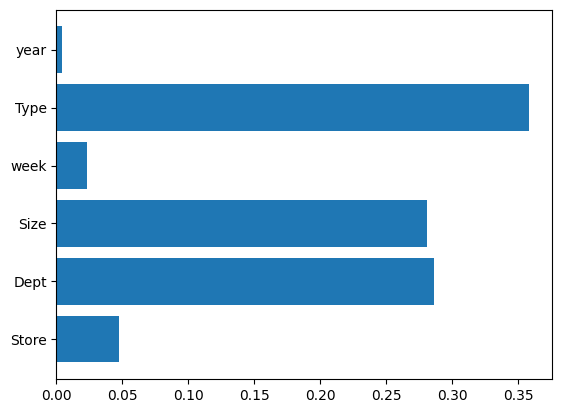

performance on evaluation
r2= 0.9882610755052794
MAE= 1072.4521701242
WMAE= 1155.201880532132
N= 369
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995462707082212
MAE=  305.1247254321656
WMAE=  300.26842939037857


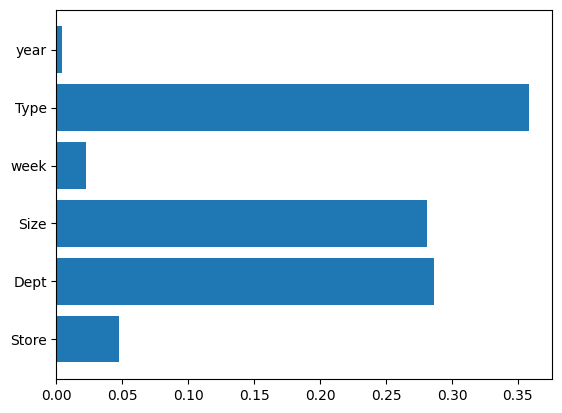

performance on evaluation
r2= 0.9882612069961492
MAE= 1072.4645637598157
WMAE= 1155.2157403723622
N= 370
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995490974160407
MAE=  304.35252374083024
WMAE=  299.46880390272025


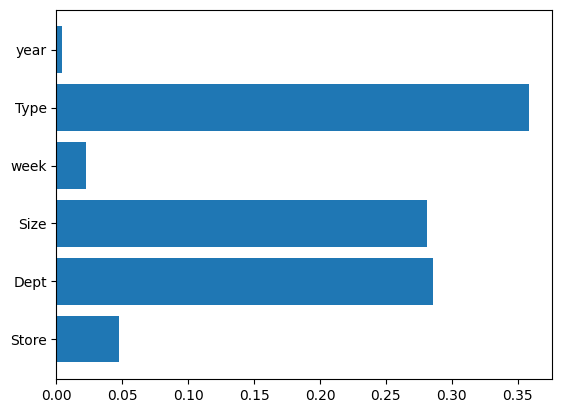

performance on evaluation
r2= 0.988261720500447
MAE= 1072.44949117656
WMAE= 1155.205966602962
N= 371
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995521518771199
MAE=  303.47016136657055
WMAE=  298.5077811772284


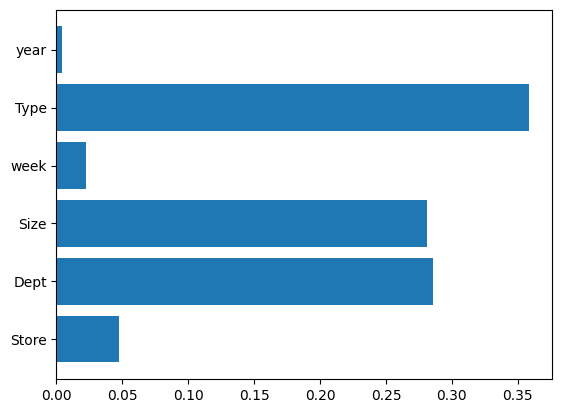

performance on evaluation
r2= 0.988259496750306
MAE= 1072.5014451630573
WMAE= 1155.2375156722096
N= 372
#(train)= 337256 #(val) 84314
performance on training
r2=  0.999555510031197
MAE=  302.5299464993045
WMAE=  297.5440065045711


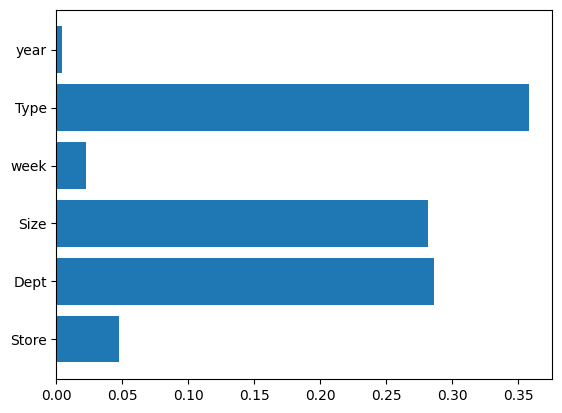

performance on evaluation
r2= 0.9882583888440176
MAE= 1072.5020707516965
WMAE= 1155.2490935000033
N= 373
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995579758774578
MAE=  301.75753039291556
WMAE=  296.85318723465986


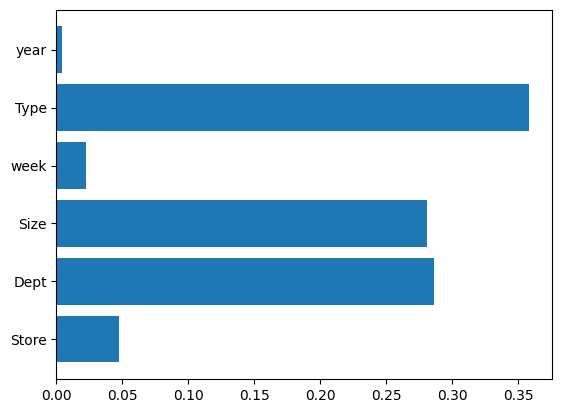

performance on evaluation
r2= 0.9882589864882663
MAE= 1072.4749736978797
WMAE= 1155.201626241891
N= 374
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995603704436681
MAE=  301.09509624451346
WMAE=  296.2277636683148


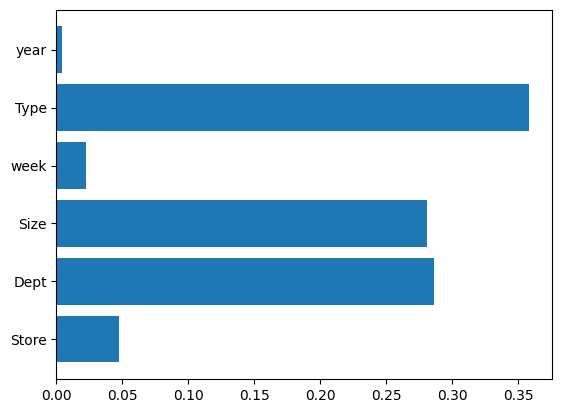

performance on evaluation
r2= 0.9882576386096829
MAE= 1072.5161635782194
WMAE= 1155.28108803457
N= 375
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995629857355105
MAE=  300.30640209653734
WMAE=  295.48823491344535


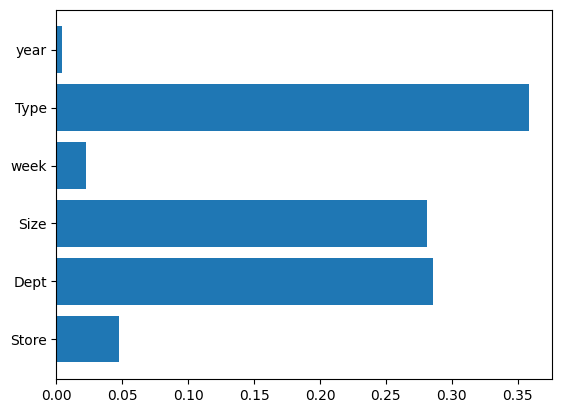

performance on evaluation
r2= 0.9882566387505466
MAE= 1072.5291589484993
WMAE= 1155.3016881137437
N= 376
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995654957385393
MAE=  299.617888523538
WMAE=  294.7889862959851


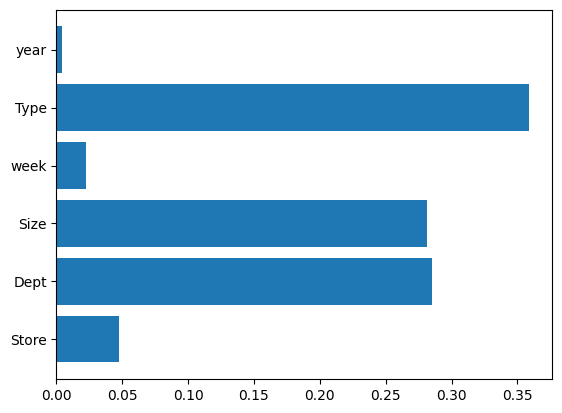

performance on evaluation
r2= 0.9882555308849752
MAE= 1072.5002338320592
WMAE= 1155.297960062153
N= 377
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995683027376498
MAE=  298.77783871745777
WMAE=  294.03402225701564


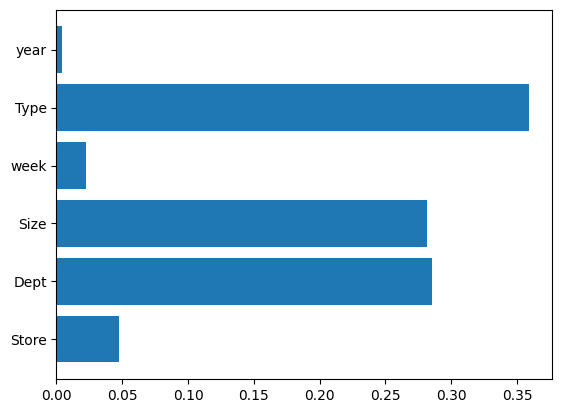

performance on evaluation
r2= 0.9882563195126627
MAE= 1072.5059877184565
WMAE= 1155.2704382333513
N= 378
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995707026336966
MAE=  298.0278595547049
WMAE=  293.3609148478608


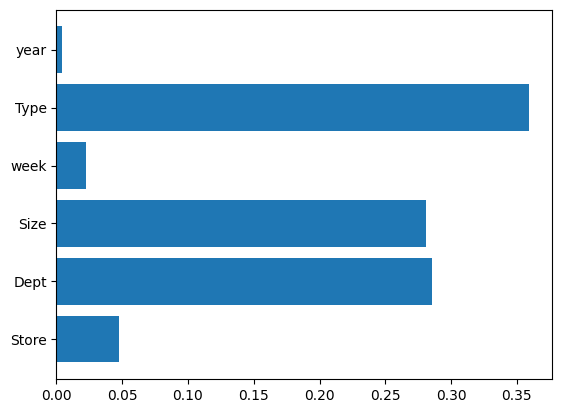

performance on evaluation
r2= 0.9882566640451755
MAE= 1072.5208272816049
WMAE= 1155.3041699489374
N= 379
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995733389183239
MAE=  297.2535668042888
WMAE=  292.53986736265597


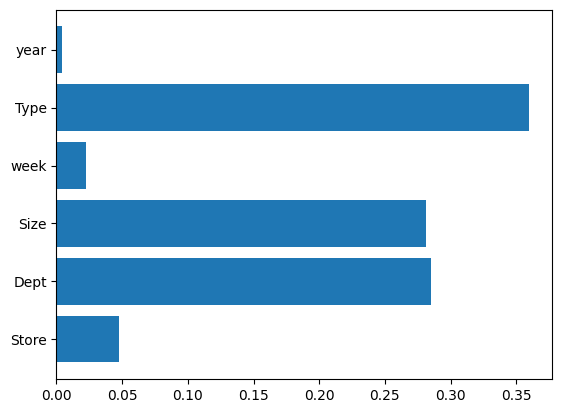

performance on evaluation
r2= 0.9882568443322468
MAE= 1072.6004771310288
WMAE= 1155.4123879741283
N= 380
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995757095445442
MAE=  296.5171062136304
WMAE=  291.8967727839516


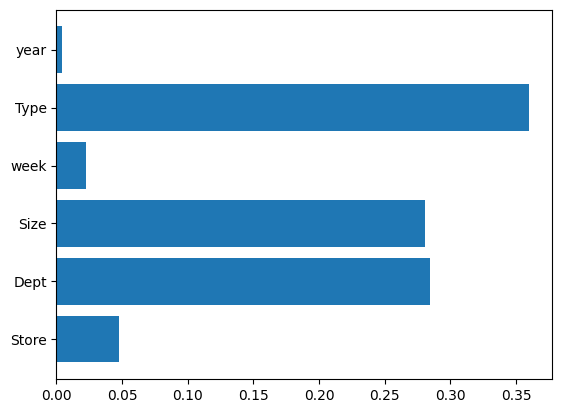

performance on evaluation
r2= 0.9882560331854363
MAE= 1072.6553722233434
WMAE= 1155.445462941421
N= 381
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995775297553522
MAE=  295.88355551254904
WMAE=  291.29120150399746


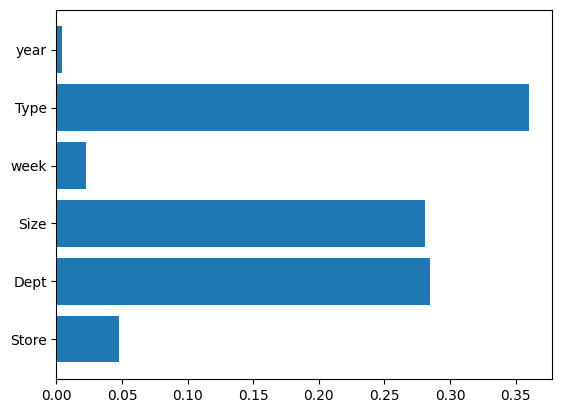

performance on evaluation
r2= 0.9882565518647185
MAE= 1072.6062261150878
WMAE= 1155.4074089119233
N= 382
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995803444123109
MAE=  295.00730816217657
WMAE=  290.4196952716948


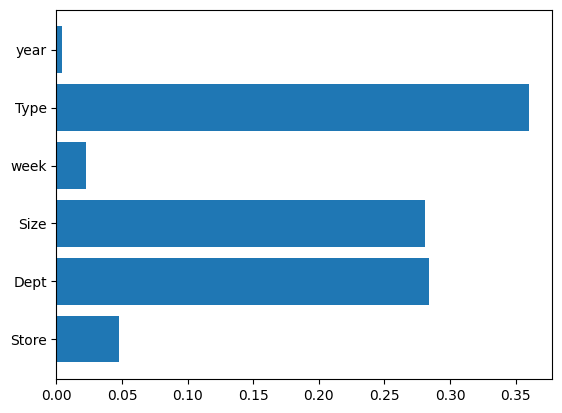

performance on evaluation
r2= 0.9882565604499985
MAE= 1072.5907603488188
WMAE= 1155.3666745627963
N= 383
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995825935026197
MAE=  294.35493031141175
WMAE=  289.71821938806096


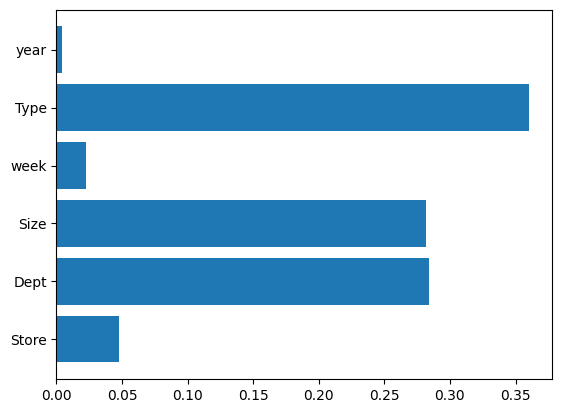

performance on evaluation
r2= 0.988256618951566
MAE= 1072.5535534115163
WMAE= 1155.3457088589487
N= 384
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995854808259725
MAE=  293.46756664398845
WMAE=  288.86898092196816


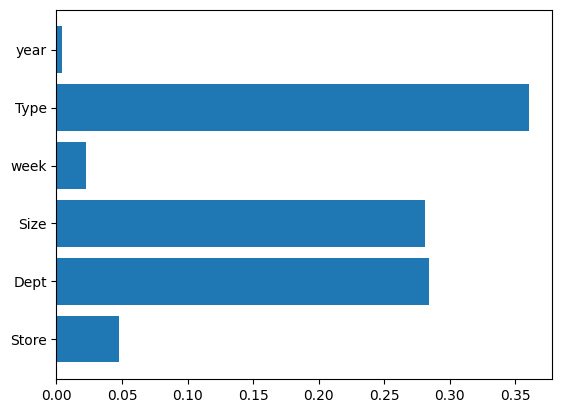

performance on evaluation
r2= 0.9882572258012737
MAE= 1072.5639133810441
WMAE= 1155.3371409124823
N= 385
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995880641650003
MAE=  292.76651467887393
WMAE=  288.15719613515057


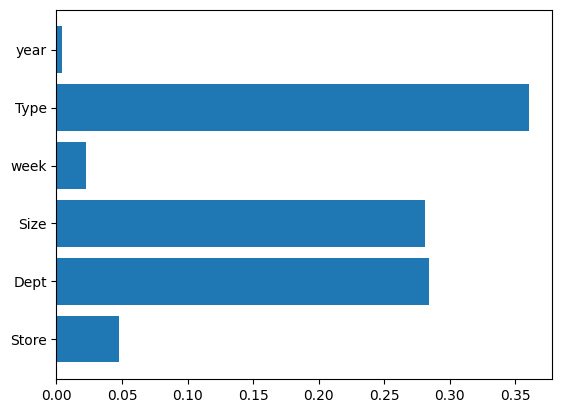

performance on evaluation
r2= 0.9882580149611124
MAE= 1072.5403375616474
WMAE= 1155.2531658538817
N= 386
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995907470026979
MAE=  291.96676244533035
WMAE=  287.1057427703986


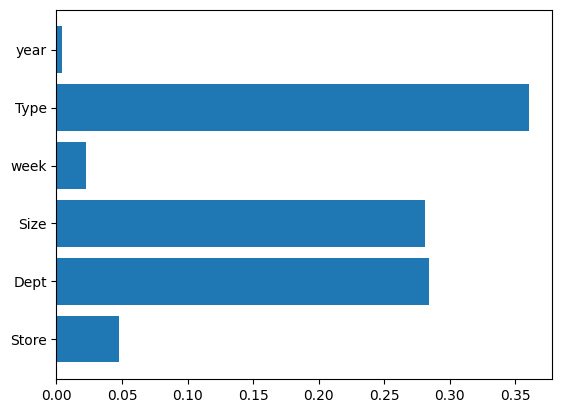

performance on evaluation
r2= 0.9882579331572432
MAE= 1072.5128990261044
WMAE= 1155.1570084579446
N= 387
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995927233281082
MAE=  291.2505467306635
WMAE=  286.3786683161304


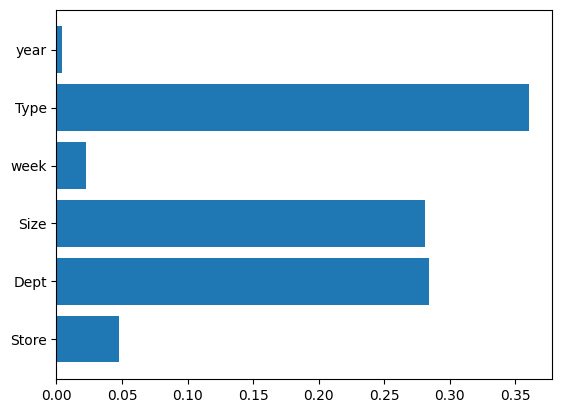

performance on evaluation
r2= 0.9882584773872195
MAE= 1072.4948103967677
WMAE= 1155.152640774108
N= 388
#(train)= 337256 #(val) 84314
performance on training
r2=  0.999594953167064
MAE=  290.52884611268775
WMAE=  285.63073766171203


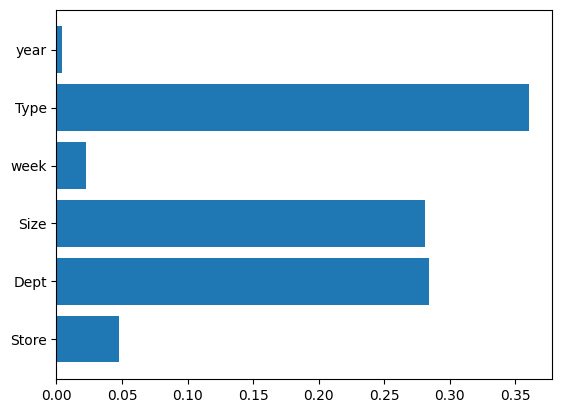

performance on evaluation
r2= 0.9882575150529068
MAE= 1072.5066481820102
WMAE= 1155.1459995986559
N= 389
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995970546428712
MAE=  289.8411596497167
WMAE=  284.9123732378352


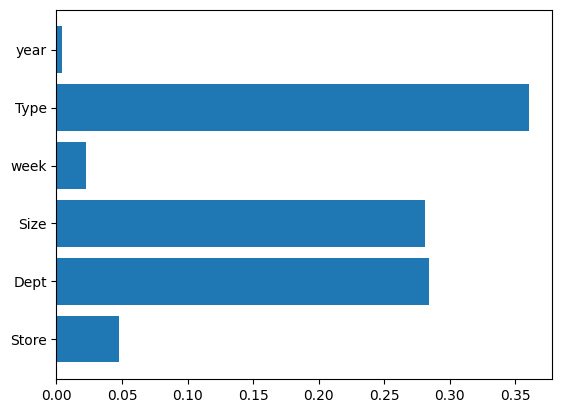

performance on evaluation
r2= 0.9882571021466088
MAE= 1072.5333757344124
WMAE= 1155.184715613933
N= 390
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9995990305662273
MAE=  289.2146807259307
WMAE=  284.24144312345135


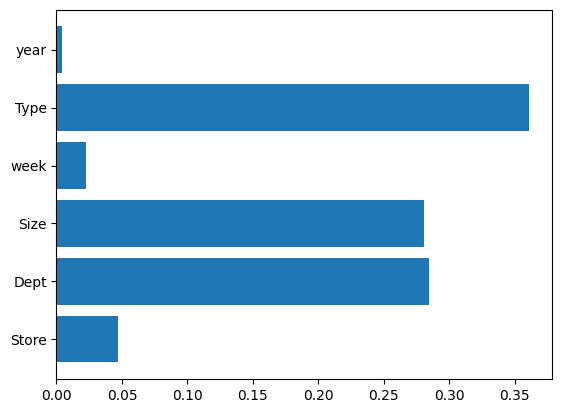

performance on evaluation
r2= 0.9882574837446878
MAE= 1072.5357938877742
WMAE= 1155.1645111156442
N= 391
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9996020930131069
MAE=  288.31089581814166
WMAE=  283.3782003209255


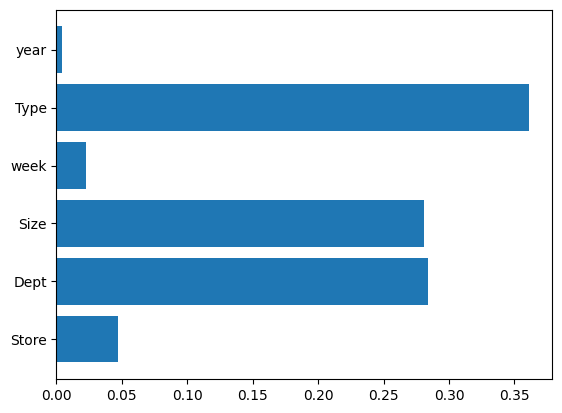

performance on evaluation
r2= 0.9882573877637099
MAE= 1072.521102495435
WMAE= 1155.1322894908672
N= 392
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9996040985199817
MAE=  287.6703277377553
WMAE=  282.69053101707476


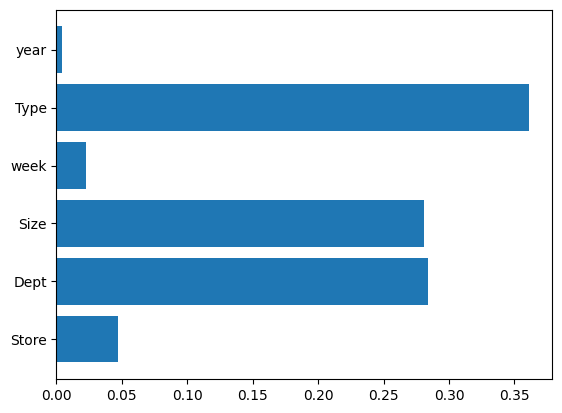

performance on evaluation
r2= 0.9882578494500394
MAE= 1072.5391482840855
WMAE= 1155.1245633523622
N= 393
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9996059604129399
MAE=  286.999970758385
WMAE=  282.0453364789112


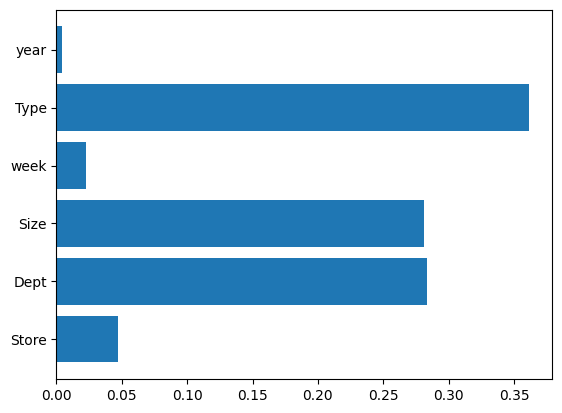

performance on evaluation
r2= 0.9882589914528744
MAE= 1072.514131443483
WMAE= 1155.081883924578
N= 394
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9996087262711939
MAE=  286.15565038719745
WMAE=  281.21008386152164


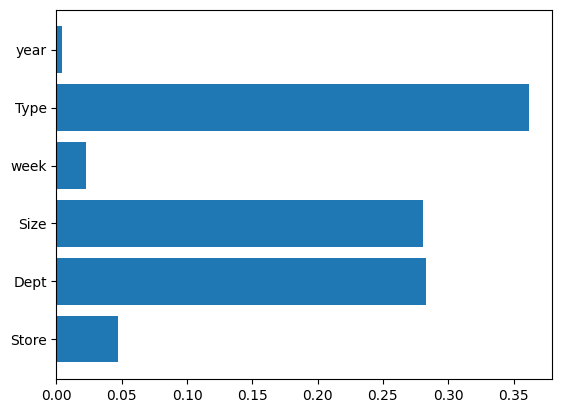

performance on evaluation
r2= 0.9882590368306013
MAE= 1072.4931636275542
WMAE= 1155.0488873329787
N= 395
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9996103644266034
MAE=  285.59680745599644
WMAE=  280.64502225017316


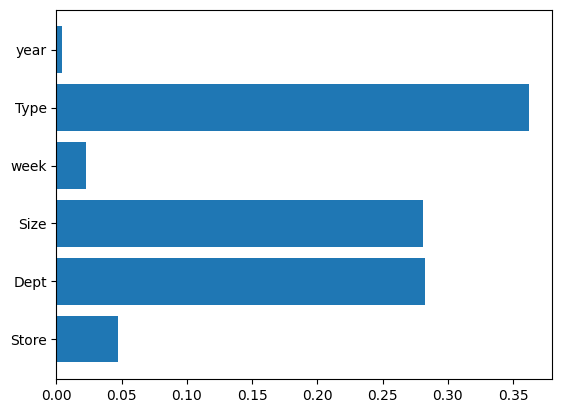

performance on evaluation
r2= 0.9882593138846024
MAE= 1072.5072942816687
WMAE= 1155.0741534378112
N= 396
#(train)= 337256 #(val) 84314
performance on training
r2=  0.999612524685167
MAE=  284.89821244438036
WMAE=  279.97300338367006


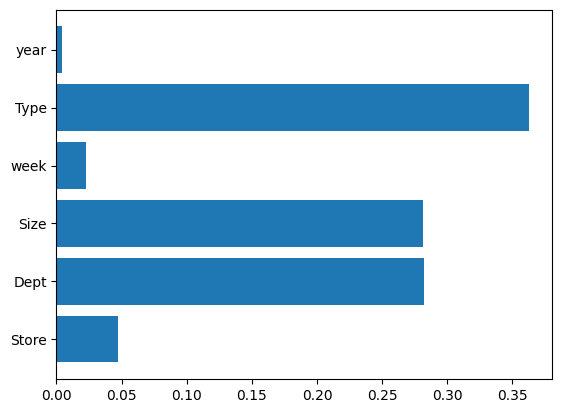

performance on evaluation
r2= 0.9882591230217341
MAE= 1072.5436404537918
WMAE= 1155.1000429074354
N= 397
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9996139088883421
MAE=  284.3924971436461
WMAE=  279.48926581140995


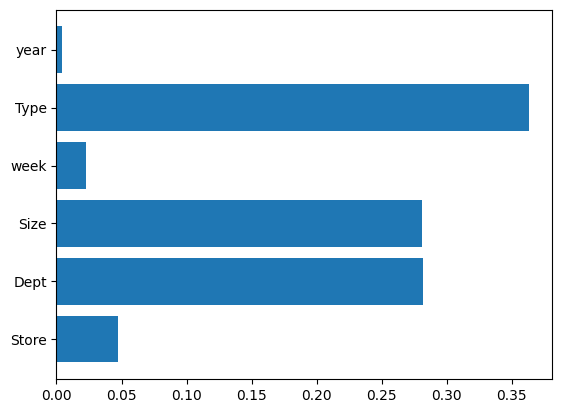

performance on evaluation
r2= 0.9882588628026646
MAE= 1072.5844234804697
WMAE= 1155.0998829655668
N= 398
#(train)= 337256 #(val) 84314
performance on training
r2=  0.99961669633298
MAE=  283.5926302073758
WMAE=  278.7115917226024


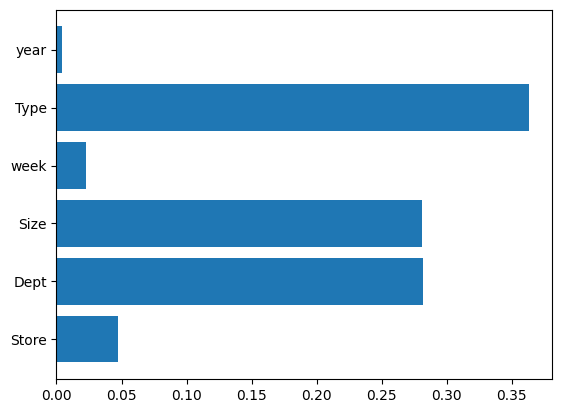

performance on evaluation
r2= 0.9882590319000975
MAE= 1072.5934002742774
WMAE= 1155.0805130811186
N= 399
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9996183631724778
MAE=  282.9895608292196
WMAE=  278.1389055831136


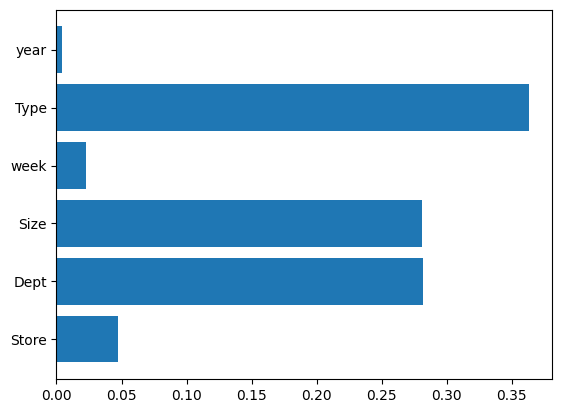

performance on evaluation
r2= 0.9882582190528776
MAE= 1072.6445901154796
WMAE= 1155.110377473188
N= 400
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9996201172917372
MAE=  282.34589148381025
WMAE=  277.4900938022944


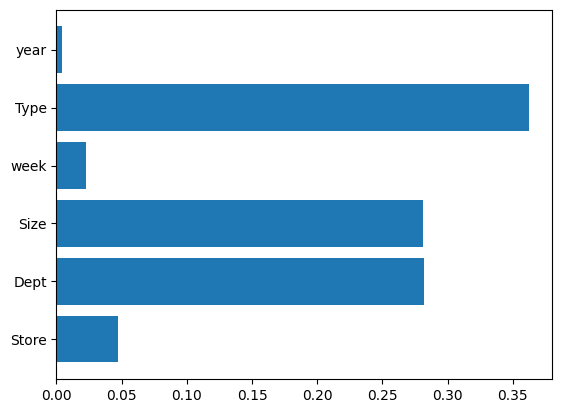

performance on evaluation
r2= 0.9882587093483485
MAE= 1072.6833860678407
WMAE= 1155.128009800659
N= 401
#(train)= 337256 #(val) 84314
performance on training
r2=  0.9996226159666198
MAE=  281.549842100295
WMAE=  276.77672035179677


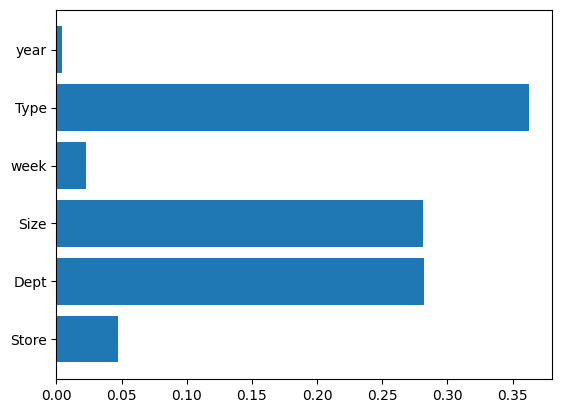

performance on evaluation
r2= 0.9882582303936814
MAE= 1072.72605945209
WMAE= 1155.1752618236108


In [111]:
# fine search for N
N_max = 500
feat= ['Weekly_Sales','Store', 'Dept', 'Size', 'week', 'Type', 'Date', 'year'] #, 'IsHoliday']
res_n_fine = {}
serie_n_fine = [[] for i in range(6)]
y_fine = range(a,b+1)
for n in y_fine:
    print('=============================')
    print("N=",n)
    tmp = train_boost(df_train, df_val, sumb = False, depth= d_best , N_ = n, features = feat )
    res_n_fine[n] = tmp
    for i in range(6):
        serie_n_fine[i].append(tmp[i])

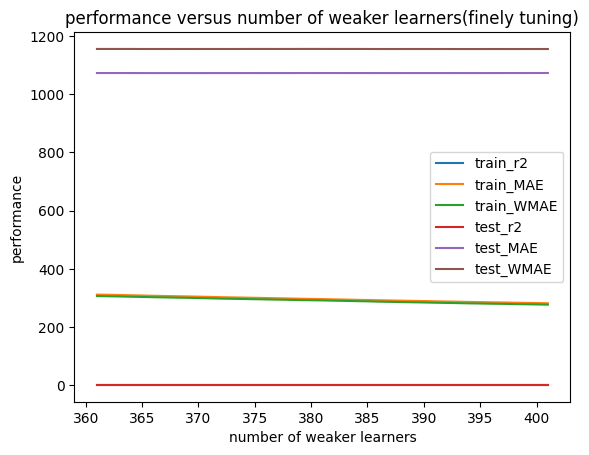

In [128]:
res_plot(serie_n_fine,y_fine,
        title= "performance versus number of weaker learners(finely tuning)",
        xlabel = 'number of weaker learners')

In [116]:
N_best = serie_n_fine[5].index(min(serie_n_fine[5])) + a
N_best

394

In [117]:
d_best, N_best

(14, 394)

#(train)= 337256 #(val) 84314
performance on training
r2=  0.9996087262711939
MAE=  286.15565038719745
WMAE=  281.21008386152164


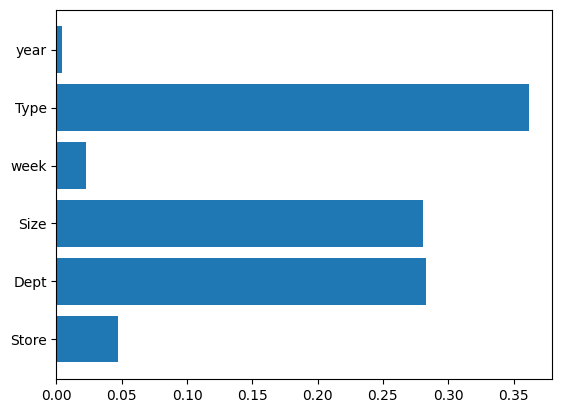

performance on evaluation
r2= 0.9882590368306013
MAE= 1072.4931636275542
WMAE= 1155.0488873329787


In [118]:
tmp = train_boost(df_train, df_val, sumb = False, depth= d_best , N_ = N_best, features = feat )


#(train)= 421570 #(val) 115064
performance on training
r2=  0.9994843687887396
MAE=  320.8731956979353
WMAE=  315.8635468640063


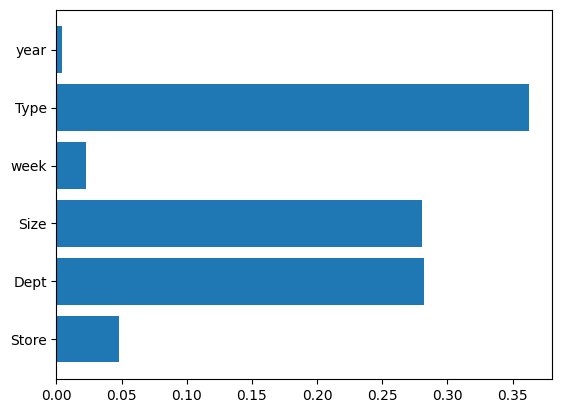

Index(['Store', 'Dept', 'Size', 'week', 'Type', 'Date', 'year'], dtype='object')


In [119]:
tmp = train_boost(df, df_test, sumb = True, depth= d_best , N_ = N_best, features = feat )


# Test preprocess

In [ ]:
df_train_all = df.copy()

df_train_all = df_train_all[ df_train_all['Weekly_Sales'].apply(lambda x: x >= 0) ]

min_sales = df_train_all['Weekly_Sales'].min()
min_sales

In [50]:
# df_test preprocess
df_test = pd.read_csv('./csv/test.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])


df_test = pd.merge(df_test, df_feat, on=['Store', 'Date', 'IsHoliday'], how = 'left')
df_test = pd.merge(df_test, df_store, on=['Store'], how = 'left' )

fill_na_cols = [ 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5' ]

for c in fill_na_cols:
    df_test[c] = df_test[c].fillna(0)

df_test['MarkDown'] = df_test[fill_na_cols].sum(axis=1)
# df['MarkDown'] = df['MarkDown3'].copy()
# df_test = df_test.drop(columns = fill_na_cols)

df_test['year'] = df_test['Date'].dt.year
df_test['week'] = df_test['Date'].dt.week
df_test['month'] = df_test['Date'].dt.month

label=LabelEncoder()

cols = ['Type', 'IsHoliday']

for c in cols:
    df_test[c] = label.fit_transform(df_test[c])
    df_test[c] = df_test[c].astype('category')
    
# df_test = df_test[ ['Date', 'Store','Dept','IsHoliday','Size','week','Type'] ] # ,'year'

/tmp/ipykernel_2157/1757414661.py:19: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_test['week'] = df_test['Date'].dt.week
